In [ ]:
import spacy 
import re 
import pandas as pd
from spacy.lang.en import English
from collections import Counter
from itertools import chain
import ahocorasick
import ast
from analysis.occ_frequency.clean_data import get_occupations_list_en, get_occupations_list
from spacy.lang.de import German
from spacy.lang.it import Italian
from spacy.lang.es import Spanish 
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from operator import itemgetter

/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/my_venv/lib64/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def stem_titles(titles):
  from nltk.stem import SnowballStemmer 
  stemmer = SnowballStemmer("italian") # Choose a language
  stems = []
  for title in titles:
     stem = stemmer.stem(title)
     stems.append(stem)
  return stems
it_occ_titles = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/it_occ_list_from_en.csv', encoding='utf-8')
it_occ_list = it_occ_titles['occupations'].to_list()
stems = stem_titles(it_occ_list)
print(stems[:10])

['astrazion', 'contabil', 'acrob', 'attor', 'attric', 'attuar', 'agopressor', 'agopuntur', 'indirizz', 'giudice arbitr']


In [ ]:
def get_occupations(df):
    new_df = df
    # print(unique_gender_counts)
    # number of biographies that returned no intro 
    print("num intros unavailable")
    print((new_df['intro'] == 'No intro available').sum())
    # remove biographies with no intro 
    new_df = new_df[new_df.intro != 'No intro available']
    print(new_df.shape[0])
    small_df = new_df.copy()
    # lowercase intro strings
    small_df['intro'] = small_df['intro'].str.casefold()
    small_df['title'] = small_df['title'].str.casefold()

    # get a set of occupation words 
    full_unique_occupations = set(stem_titles(it_occ_list))
   
    small_df['intro'] = small_df['intro'].astype(str)
    small_df['title'] = small_df['title'].astype(str)
    
    print(small_df.dtypes)
    # want to find overlapping terms in the intros column and the wikidata occupation words set 
    automaton = ahocorasick.Automaton()
    for id, term in enumerate(full_unique_occupations):
        automaton.add_word(term, (term))
    automaton.remove_word('-')
    automaton.make_automaton()
    def find_terms_en(text):
        return list(term for _, term in automaton.iter(text))
    def find_terms_de(text):
        words = list(re.findall(r'\b\w+\b', text.lower()))  # Tokenize text into words
        matches = list(term for _, term in automaton.iter(text) if term.lower() in words)
        return matches
    def find_terms_stems1(text):
      matching_tokens = []
      substrings = list(full_unique_occupations)
      tokens = text.split()
      for token in tokens:
        if any(sub in token for sub in substrings):
          matching_tokens.append(token)
      return matching_tokens
    
    def find_terms_stems(text):
      # ner = spacy.load('en_core_web_sm') 
      # ner = spacy.load('de_core_news_sm')
      ner = spacy.load('it_core_news_sm') 
      # ner = spacy.load('es_core_news_sm')
      doc = ner(text) 
      occupational_titles = list(full_unique_occupations)
      matched_occupations = []
      for ent in doc: 
        if any(sub in ent.text.casefold() for sub in occupational_titles):
          if not ent.ent_type_:
              # matched_occupations.append(ent.text)
              matched_occupations.append({ent.text: ent.morph.get("Gender")})
        # print(ent.text, ent.pos_, ent.dep_)
          # print(ent,ent.morph.get("Gender"))
      return (matched_occupations)
    
    # small_df['overlapping_occupations'] = small_df['intro'].apply(find_terms_stems)
    # small_df['overlapping_occupations_sentence1'] = small_df['first_sentence'].apply(find_terms_stems)
    # want to see if male occupation names show up in title field as last names 
    # small_df['occupation_in_last_name'] = small_df['title'].apply(find_terms_stems)
    small_df['overlapping_occupations_sentence1'] = small_df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    occ_counts_counter = Counter(
    key
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for key in d.keys()
    )

    occ_gender_counts_counter = Counter(
    value
    for row in small_df['overlapping_occupations_sentence1']
    for d in row
    for values in d.values()
    for value in values
    )
   
    # overlapping_occ_counts = Counter(chain.from_iterable([small_df['overlapping_occupations_sentence1'].keys()]))
    # print(small_df[['wikidata_code','intro', 'overlapping_occupations']].head(20))
    print(occ_counts_counter)
    print(occ_gender_counts_counter)
    smaller_df = small_df[small_df['overlapping_occupations_sentence1'].map(len)>0]
    # smaller_df = smaller_df[smaller_df['overlapping_occupations'].map(len)>0]

    print("length of dataset:")
    print(small_df.shape[0])
    print("first sentences with occ title found:", smaller_df.shape[0])
    return occ_counts_counter

In [ ]:

it_female_df2 = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/it_female_occ.csv', encoding='utf-8')
it_female_df2 = it_female_df2[it_female_df2['gender'] == 'female']
female_occ_counts2 = get_occupations(it_female_df2)

num intros unavailable
0
53770
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'attrice': 12453, 'cantante': 3811, 'scrittrice': 3182, 'modella': 2770, 'cestista': 2680, 'politica': 2126, 'vincitrice': 1632, 'calciatrice': 1526, 'canadese': 1302, 'principessa': 1237, 'moglie': 1194, 'giornalista': 1048, 'conduttrice': 1043, 'nuotatrice': 1014, 'cantautrice': 915, 'figlia': 900, 'svedese': 792, 'sciatrice': 757, 'nobildonna': 714, 'regina': 710, 'poetessa': 710, 'ballerina': 685, 'schermitrice': 679, 'doppiatrice': 675, 'allenatrice': 633, 'sceneggiatrice': 628, 'produttrice': 61

In [ ]:

it_male_df2 = pd.read_csv('/mount/arbeitsdaten/studenten2/caulfiea/masters_thesis/sets_for_analysis/redo/it_male_occ.csv', encoding='utf-8')
it_male_df2 = it_male_df2[it_male_df2['gender'] == 'male']
male_occ_counts2 = get_occupations(it_male_df2)

num intros unavailable
0
56990
Unnamed: 0                            int64
wikidata_code                        object
title                                object
intro                                object
gender                               object
occupations                          object
first_sentence                       object
overlapping_occupations              object
overlapping_occupations_sentence1    object
occupation_in_last_name              object
dtype: object
Counter({'calciatore': 10962, 'politico': 4612, 'allenatore': 3162, 'attore': 3132, 'cestista': 2377, 'scrittore': 2319, 'pittore': 1666, 'giocatore': 1401, 'compositore': 1379, 'giornalista': 1042, 'portiere': 996, 'produttore': 989, 'poeta': 967, 'sceneggiatore': 907, 'storico': 888, 'cantante': 840, 'canadese': 707, 'vincitore': 683, 'direttore': 663, 'svedese': 661, 'imprenditore': 592, 'architetto': 562, 'pilota': 550, 'musicista': 549, 'scultore': 487, 'filosofo': 456, 'medico': 446, 'ingegnere': 428, 'a

In [6]:
def get_occ_gender_counts(df):
    result = {}
    df['overlapping_occupations_sentence1'] = df['overlapping_occupations_sentence1'].apply(ast.literal_eval)
    # Define the expected gender categories
    genders = ['Fem', 'Masc', 'Neutral']
    occupation_list = df['overlapping_occupations_sentence1'].tolist()
    # Loop through each item in the list
    for items in occupation_list :
        for item in items:
            for profession, gender_list in item.items():
                # Ensure the profession is in the result dictionary
                if profession not in result:
                    result[profession] = {g: 0 for g in genders}

                if not gender_list:
                    result[profession]['Neutral'] += 1
                else:
                    # Increment the corresponding gender count
                    for gender in gender_list:
                        if gender in result[profession]:
                            result[profession][gender] += 1
    # print(result)
    return result

In [15]:
summary_df = pd.DataFrame(occupation_genders).T.fillna(0).astype(int)

In [16]:
# Step 1: Add a total column
summary_df['Total'] = summary_df.sum(axis=1)

# Step 2: Calculate male percentage
summary_df['Male_Percentage'] = summary_df['Masc'] / summary_df['Total']

# Step 3: Sort by male percentage (descending)
sorted_by_male = summary_df.sort_values(by='Masc', ascending=False)


print(sorted_by_male[['Fem','Masc', 'Total', 'Male_Percentage']].head(30))

               Fem  Masc  Total  Male_Percentage
cestista       646  1147   2680         0.427985
film             0   319    319         1.000000
duchessa       192   313    590         0.530508
interpretato     0   267    267         1.000000
presidente       0   236    237         0.995781
pattinatrice   236   211    448         0.470982
compositrice   198   207    407         0.508600
imperatore       0   203    203         1.000000
musicista      103   194    342         0.567251
portiere         0   138    138         1.000000
rappresentato    0   133    133         1.000000
musical          0   125    125         1.000000
doppiaggio       0   119    119         1.000000
figlio           0    97     97         1.000000
medico           0    95     95         1.000000
ministro         0    94     94         1.000000
pittrice       439    93    545         0.170642
avvocato         0    85     85         1.000000
tuffatrice     103    73    177         0.412429
figli            0  

In [ ]:
def make_plot(overlapping_occ_counts):
    # get bar chart of top 30 occupations
    ten_items = dict(sorted(overlapping_occ_counts.items(), key=itemgetter(1), reverse=True)[:30])
    print(ten_items)
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), averages, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Percentage of Occupational Title Occurences in Italian Female Data")
    plt.show()

{'attrice': 12453, 'cantante': 3811, 'scrittrice': 3182, 'modella': 2770, 'cestista': 2680, 'politica': 2126, 'vincitrice': 1632, 'calciatrice': 1526, 'principessa': 1237, 'moglie': 1194, 'giornalista': 1048, 'conduttrice': 1043, 'nuotatrice': 1014, 'cantautrice': 915, 'figlia': 900, 'sciatrice': 757, 'nobildonna': 714, 'regina': 710, 'poetessa': 710, 'ballerina': 685, 'schermitrice': 679, 'doppiatrice': 675, 'allenatrice': 633, 'sceneggiatrice': 628, 'produttrice': 611, 'duchessa': 590, 'pittrice': 545, 'pattinatrice': 448, 'giocatrice': 415, 'compositrice': 407}
30
46738.0
[0.26644272326586504, 0.08153964654028842, 0.06808164662587188, 0.05926654970259746, 0.057340921733921, 0.045487611793401515, 0.03491805383199966, 0.03265009200222517, 0.026466686636141896, 0.025546664384440927]


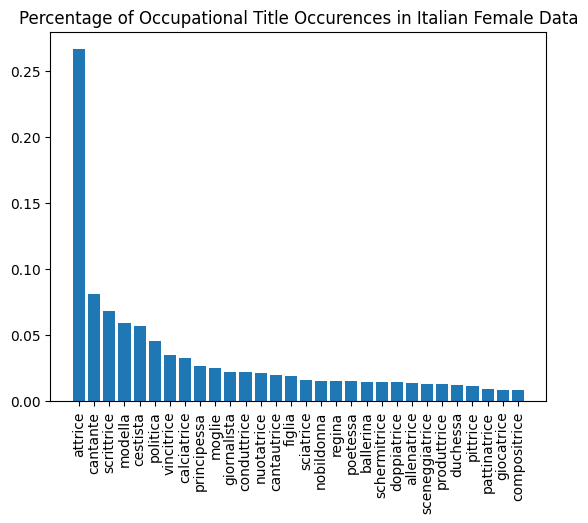

In [32]:
make_plot(female_occ_counts2)

{'calciatore': 10962, 'politico': 4612, 'allenatore': 3162, 'attore': 3132, 'cestista': 2377, 'scrittore': 2319, 'pittore': 1666, 'giocatore': 1401, 'compositore': 1379, 'giornalista': 1042, 'portiere': 996, 'produttore': 989, 'poeta': 967, 'sceneggiatore': 907, 'storico': 888, 'cantante': 840, 'vincitore': 683, 'direttore': 663, 'imprenditore': 592, 'architetto': 562, 'pilota': 550, 'musicista': 549, 'scultore': 487, 'filosofo': 456, 'medico': 446, 'ingegnere': 428, 'avvocato': 420, 'autore': 386, 'cantautore': 379, 'tecnico': 378}
30
44618.0
[0.24568559774082208, 0.1033663543861222, 0.07086825944686001, 0.07019588506880631, 0.05327446322112152, 0.051974539423551035, 0.037339190461248825, 0.0313998834551078, 0.030906808911201757, 0.023353803397731857]


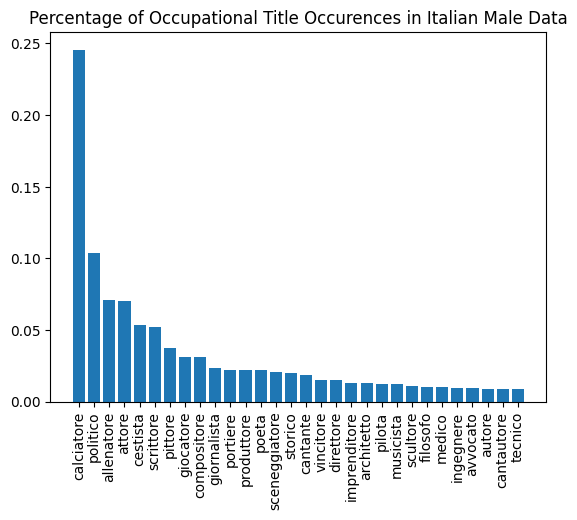

In [30]:
make_plot(male_occ_counts2)

In [8]:
female_occ_dict = dict(sorted(female_occ_counts2.items(), key=itemgetter(1), reverse=True))
professions_it = ["medico","medica","capitano","capitana","sindaco","sindaca","avvocato",'avvocata',"avvocatessa","architetto","architetta","sportivo","sportiva","sottosegretario",
"sottosegretaria","allenatore","allenatrice","critico","critica","magistrato","magistrata","deputato","deputata","ministro","ministra","senatore","senatrice","dottore","dottoressa","assessore","assessora",
"carabiniere","carabiniera","deputato","deputata","direttore","direttrice", "conduttore","conduttrice"]

In [9]:
def filter_dict(pair):
    key,value = pair
    if key in professions_it:
        return True
    else:
        return False

filtered_professions = dict(filter(filter_dict, female_occ_dict.items()))
print(filtered_professions)

{'conduttrice': 1043, 'allenatrice': 633, 'direttrice': 268, 'critica': 167, 'deputata': 136, 'senatrice': 111, 'medico': 95, 'ministro': 94, 'avvocato': 85, 'avvocata': 76, 'capitano': 52, 'architetta': 37, 'sindaco': 34, 'medica': 29, 'architetto': 29, 'sindaca': 27, 'direttore': 25, 'magistrata': 22, 'magistrato': 15, 'sottosegretaria': 15, 'dottoressa': 14, 'avvocatessa': 13, 'ministra': 12, 'sottosegretario': 12, 'critico': 9, 'allenatore': 8, 'deputato': 8, 'senatore': 6, 'capitana': 6, 'assessore': 6, 'conduttore': 2, 'dottore': 2}


In [33]:
def make_plot2(overlapping_occ_counts):
    # get bar chart of top 20 occupations
    ten_items = overlapping_occ_counts
    values = list(ten_items.values())
    values = [float(i) for i in values]
    values_sum = sum(values)
    print(values_sum)
    averages = [x / values_sum for x in values]
    print(averages[:10])
    plt.bar(range(len(ten_items)), values, align='center')
    plt.xticks(range(len(ten_items)), list(ten_items.keys()))
    plt.xticks(rotation=90)
    plt.title("Occurrences of Occupational Title Occurences in Italian Female Data")

566.0
[0.196113074204947, 0.19434628975265017, 0.12014134275618374, 0.12014134275618374, 0.06890459363957598, 0.05653710247349823, 0.04946996466431095, 0.022968197879858657, 0.0176678445229682, 0.0176678445229682]


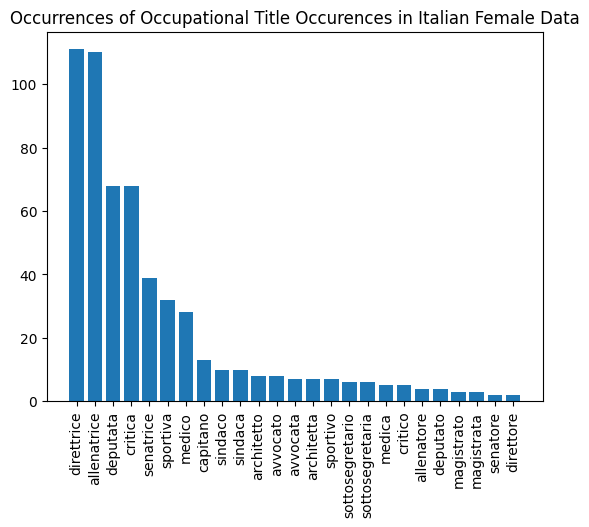

In [39]:
make_plot2(filtered_professions)

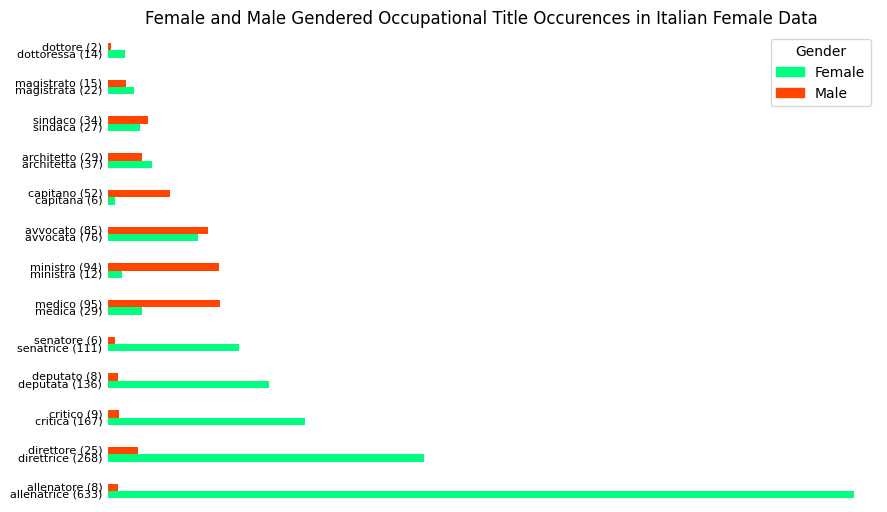

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = {'allenatrice': 633, 'direttrice': 268, 'critica': 167, 'deputata': 136, 'senatrice': 111, 'medico': 95, 'ministro': 94, 'avvocato': 85, 'avvocata': 76, 'capitano': 52, 'architetta': 37, 'sindaco': 34, 'medica': 29, 'architetto': 29, 'sindaca': 27, 'direttore': 25, 'magistrata': 22, 'magistrato': 15, 'sottosegretaria': 15, 'dottoressa': 14, 'ministra': 12, 'sottosegretario': 12, 'critico': 9, 'allenatore': 8, 'deputato': 8, 'senatore': 6, 'capitana': 6, 'assessore': 6, 'dottore': 2}

data = {
    'group_2': {'female': ('allenatrice', 633), 'male': ('allenatore', 8)},
    'group_3': {'female': ('direttrice', 268), 'male': ('direttore', 25)},
    'group_4': {'female': ('critica', 167), 'male': ('critico', 9)},
    'group_5': {'female': ('deputata', 136), 'male': ('deputato', 8)},
    'group_6': {'female': ('senatrice', 111), 'male': ('senatore', 6)},
    'group_7': {'female': ('medica', 29), 'male': ('medico', 95)},
    'group_8': {'female': ('ministra', 12), 'male': ('ministro', 94)},
    'group_9': {'female': ('avvocata', 76), 'male': ('avvocato', 85)},
    'group_10': {'female': ('capitana', 6), 'male': ('capitano', 52)},
    'group_11': {'female': ('architetta', 37), 'male': ('architetto', 29)},
    'group_12': {'female': ('sindaca', 27), 'male': ('sindaco', 34)},
    'group_13': {'female': ('magistrata',22), 'male': ('magistrato', 15)},
    'group_14': {'female': ('sottosegretaria', 15), 'male': ('sottosegretario', 12)},
    'group_14': {'female': ('dottoressa', 14), 'male': ('dottore', 2)},
}

genders = ['female', 'male', 'neutral']
colors = {'female': 'springgreen', 'male': 'orangered', 'neutral': 'blueviolet'}

group_names = list(data.keys())
n_groups = len(group_names)
bar_height = 0.2
# y = np.arange(n_groups)
group_spacing = 1.0  # try 1.0 to 1.5 for more space
y = np.arange(n_groups) * group_spacing

fig, ax = plt.subplots(figsize=(9, 5))

for i, gender in enumerate(genders):
    for j, group in enumerate(group_names):
        if gender in data[group]:
            label, value = data[group][gender]
            ypos = y[j] + i * bar_height
            ax.barh(ypos, value, height=bar_height, color=colors[gender])
            # Label to the left of the bar
            ax.text(-5, ypos, f'{label} ({value})', ha='right', va='center', fontsize=8)

# Axis settings
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-0.2, y[-1] + bar_height * len(genders))
ax.set_xlim(-20, max(v[1] for g in data.values() for v in g.values()) + 20)
for spine in ax.spines.values():
    spine.set_visible(False)

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[g]) for g in genders if any(g in d for d in data.values())]
labels = [g.capitalize() for g in genders if any(g in d for d in data.values())]
ax.legend(handles, labels, title='Gender', loc='upper right')

plt.tight_layout()
plt.title("Female and Male Gendered Occupational Title Occurences in Italian Female Data")
plt.show()

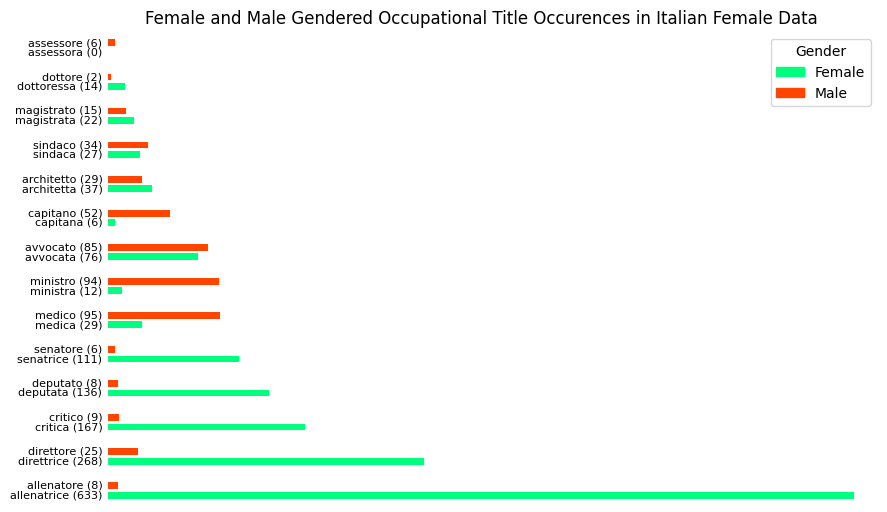

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data = {'allenatrice': 633, 'direttrice': 268, 'critica': 167, 'deputata': 136, 'senatrice': 111, 'medico': 95, 'ministro': 94, 'avvocato': 85, 'avvocata': 76, 'capitano': 52, 'architetta': 37, 'sindaco': 34, 'medica': 29, 'architetto': 29, 'sindaca': 27, 'direttore': 25, 'magistrata': 22, 'magistrato': 15, 'sottosegretaria': 15, 'dottoressa': 14, 'ministra': 12, 'sottosegretario': 12, 'critico': 9, 'allenatore': 8, 'deputato': 8, 'senatore': 6, 'capitana': 6, 'assessore': 6, 'dottore': 2}

data = {
    'group_2': {'female': ('allenatrice', 633), 'male': ('allenatore', 8)},
    'group_3': {'female': ('direttrice', 268), 'male': ('direttore', 25)},
    'group_4': {'female': ('critica', 167), 'male': ('critico', 9)},
    'group_5': {'female': ('deputata', 136), 'male': ('deputato', 8)},
    'group_6': {'female': ('senatrice', 111), 'male': ('senatore', 6)},
    'group_7': {'female': ('medica', 29), 'male': ('medico', 95)},
    'group_8': {'female': ('ministra', 12), 'male': ('ministro', 94)},
    'group_9': {'female': ('avvocata', 76), 'male': ('avvocato', 85)},
    'group_10': {'female': ('capitana', 6), 'male': ('capitano', 52)},
    'group_11': {'female': ('architetta', 37), 'male': ('architetto', 29)},
    'group_12': {'female': ('sindaca', 27), 'male': ('sindaco', 34)},
    'group_13': {'female': ('magistrata',22), 'male': ('magistrato', 15)},
    'group_14': {'female': ('sottosegretaria', 15), 'male': ('sottosegretario', 12)},
    'group_14': {'female': ('dottoressa', 14), 'male': ('dottore', 2)},
    'group_15': {'female': ('assessora', 0), 'male': ('assessore', 6)},
}

genders = ['female', 'male', 'neutral']
colors = {'female': 'springgreen', 'male': 'orangered', 'neutral': 'blueviolet'}

group_names = list(data.keys())
n_groups = len(group_names)
bar_height = 0.2
# y = np.arange(n_groups)
group_spacing = 1.0  # try 1.0 to 1.5 for more space
y = np.arange(n_groups) * group_spacing

fig, ax = plt.subplots(figsize=(9, 5))

for i, gender in enumerate(genders):
    for j, group in enumerate(group_names):
        if gender in data[group]:
            label, value = data[group][gender]
            # ypos = y[j] + i * bar_height
            spacing_factor = 1.4  # try 1.2–1.5 for light-to-generous spacing
            ypos = y[j] + i * bar_height * spacing_factor
            ax.barh(ypos, value, height=bar_height, color=colors[gender])
            # Label to the left of the bar
            ax.text(-5, ypos, f'{label} ({value})', ha='right', va='center', fontsize=8)

# Axis settings
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-0.2, y[-1] + bar_height * len(genders))
ax.set_xlim(-20, max(v[1] for g in data.values() for v in g.values()) + 20)
for spine in ax.spines.values():
    spine.set_visible(False)

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[g]) for g in genders if any(g in d for d in data.values())]
labels = [g.capitalize() for g in genders if any(g in d for d in data.values())]
ax.legend(handles, labels, title='Gender', loc='upper right')

plt.tight_layout()
plt.title("Female and Male Gendered Occupational Title Occurences in Italian Female Data")
plt.show()